# Initial Data Exploration of Planet Reflectance Values

currently (2-13) we've only got snow-cover imagery, so here goes with that analysis. 

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 9)
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 18


In [54]:

datafile = "../images/snow/PROVISIONAL_snow_datatable.csv"
nosnowfile = "../images/no-snow/PROVISIONAL_nosnow_datatable.csv"
data = pd.read_csv(datafile)
nosnow_data = pd.read_csv(nosnowfile)


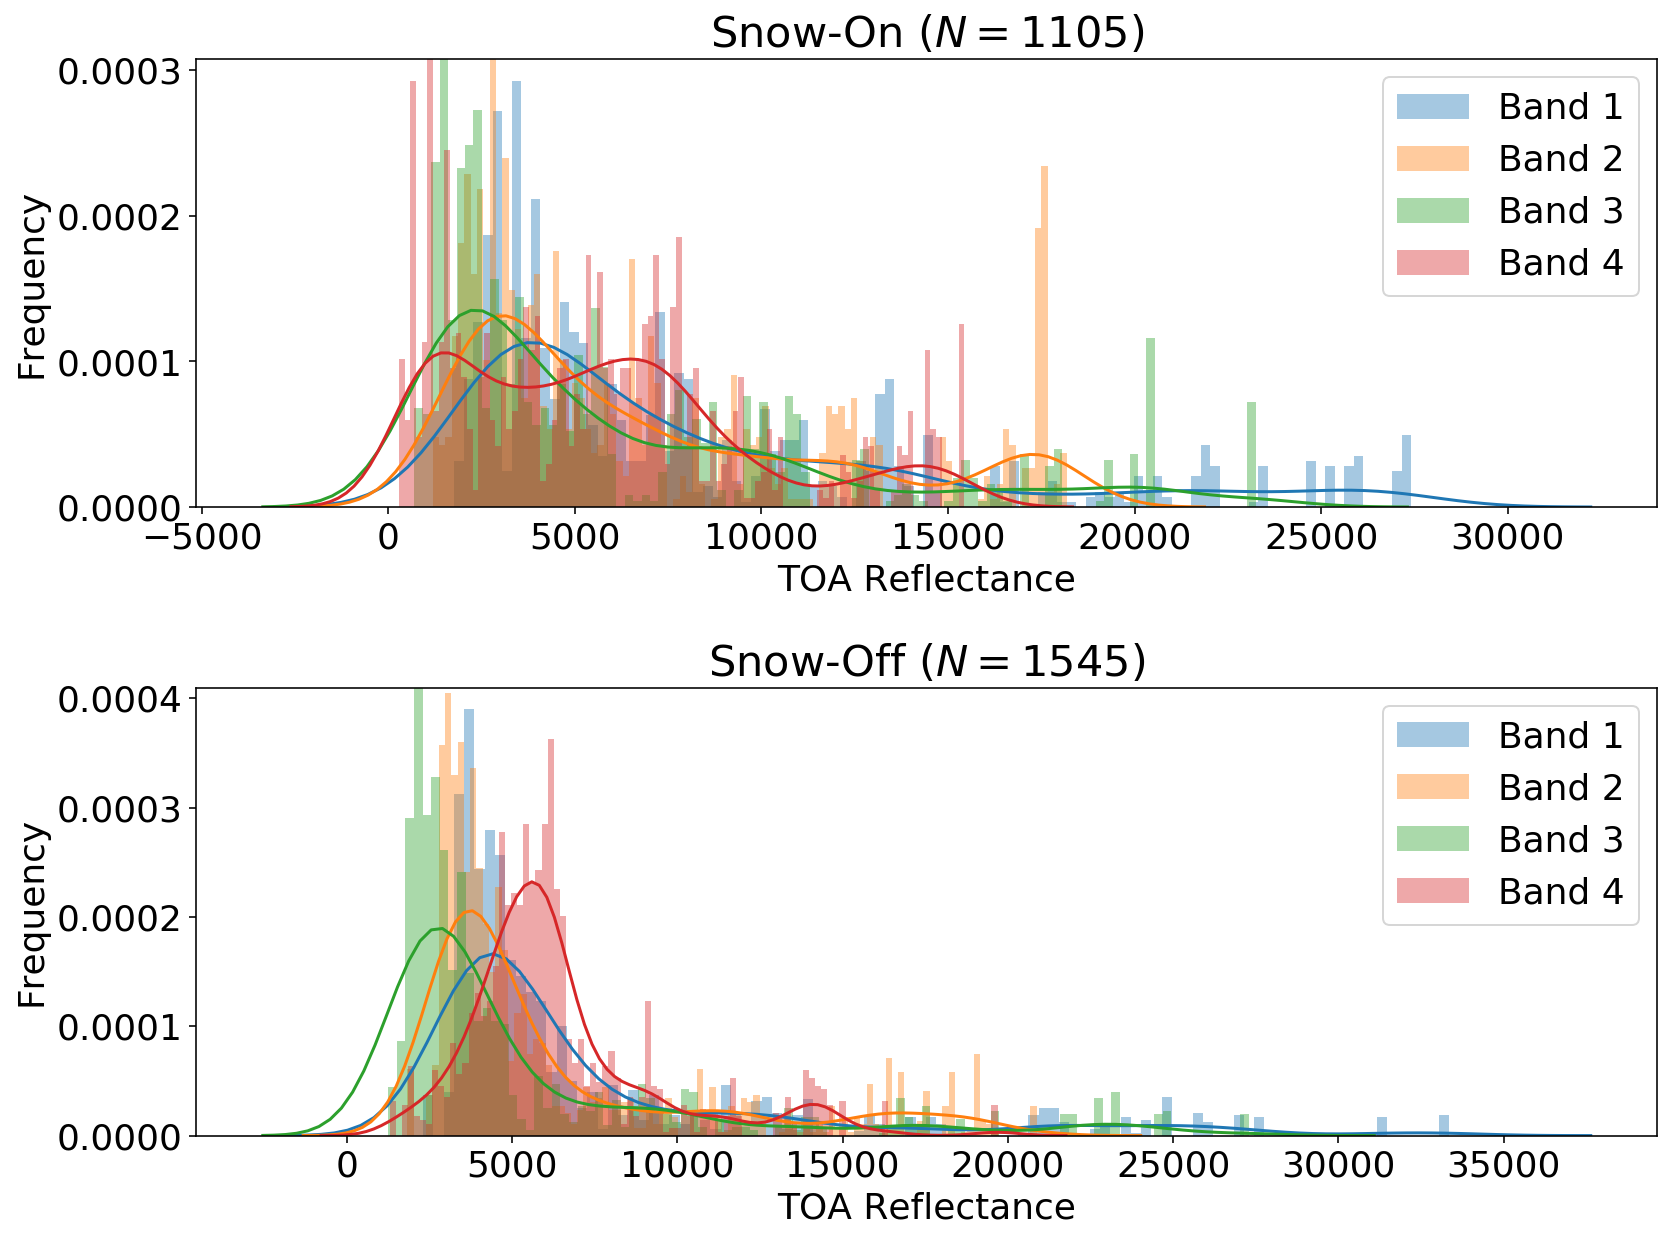

In [55]:
f, (ax1, ax2) = plt.subplots(2, 1)

bins = 100
sns.distplot(data.band1, label='Band 1', bins=bins, ax=ax1)
sns.distplot(data.band2, label='Band 2', bins=bins, ax=ax1)
sns.distplot(data.band3, label="Band 3", bins=bins, ax=ax1)
sns.distplot(data.band4, label='Band 4', bins=bins, ax=ax1)
ax1.set_xlabel("TOA Reflectance")
ax1.set_ylabel("Frequency")
ax1.set_title("Snow-On ($N = {n}$)".format(n = len(data)))
#ax1.set_xlim(0, 1)
ax1.legend()

bins = 100
sns.distplot(nosnow_data.band1, label='Band 1', bins=bins, ax=ax2)
sns.distplot(nosnow_data.band2, label='Band 2', bins=bins, ax=ax2)
sns.distplot(nosnow_data.band3, label="Band 3", bins=bins, ax=ax2)
sns.distplot(nosnow_data.band4, label='Band 4', bins=bins, ax=ax2)
ax2.set_xlabel("TOA Reflectance")
ax2.set_ylabel("Frequency")
ax2.set_title("Snow-Off ($N = {n}$)".format(n = len(nosnow_data)))
#ax2.set_xlim(0, 1)
ax2.legend()
f.tight_layout()
plt.savefig("histcompare.png", dpi=100)

In [4]:
!ls

data-exploration.ipynb	pipeline-all.py			  sensor_bbox.json
data extract.ipynb	pipeline-all-with-download.ipynb  Untitled1.ipynb
histcompare.png		pipeline-all-with-download.py	  Untitled2.ipynb
image_utils		PROVISIONAL_datatable.csv	  Untitled.ipynb
locations.html		PROVISIONAL_nosnow_datatable.csv
pipeline-all.ipynb	search-test.ipynb


In [20]:
bands = ['band1', 'band2', 'band3', 'band4']
nosnowbands = nosnow_data[bands]
nosnowbands['label'] = 0
snowbands = data[bands]
snowbands['label'] = 1

merged = pd.concat([snowbands, nosnowbands], axis=0)
merged.head()

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,band1,band2,band3,band4,label
0,5888,5137,3943,7086,1
1,5981,5216,4107,7318,1
2,5818,5024,3855,7025,1
3,5796,4992,3856,6739,1
4,5880,5093,3967,7061,1


In [21]:
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
import numpy as np

In [24]:
bands_scaled = StandardScaler().fit_transform(merged[bands])
bands_scaled.shape

(2650, 4)

In [29]:

km = cluster.KMeans(n_clusters = 2).fit_predict(bands_scaled)

In [30]:
km

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [31]:
incorrect = sum(abs(km - merged.label)) / len(km) # % incorrect
correct = 1-incorrect
print(correct)

0.570566037735849


In [33]:
spectral = cluster.SpectralClustering(
        n_clusters=2, eigen_solver='arpack',
        affinity="nearest_neighbors").fit_predict(merged[bands])

/home/ec2-user/miniconda3/envs/imageprocess2/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [34]:
incorrect = sum(abs(spectral - merged.label)) / len(spectral) # % incorrect
correct = 1-incorrect
print(correct)

0.5901886792452831


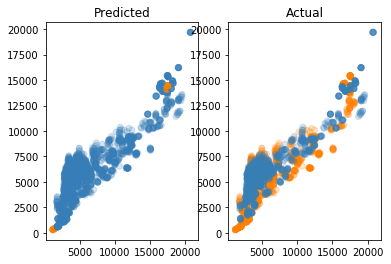

In [35]:
preds = spectral
fig, (ax1, ax2) = plt.subplots(1, 2)
colors = np.array(['#377eb8', '#ff7f00'])
ax1.scatter(merged['band2'], merged['band4'], color=colors[preds], alpha=0.2)
ax1.set_title("Predicted")
ax2.scatter(merged['band2'], merged['band4'], color=colors[merged.label], alpha=0.2)
ax2.set_title("Actual")
f.tight_layout()

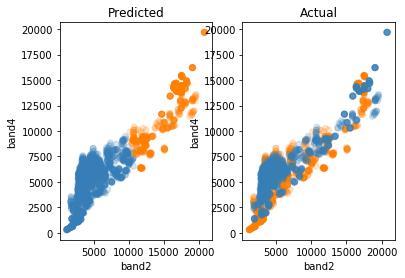

In [36]:
preds = km
b1 = 'band2'
b2 = 'band4'
fig, (ax1, ax2) = plt.subplots(1, 2)
colors = np.array(['#377eb8', '#ff7f00'])
ax1.scatter(merged[b1], merged[b2], color=colors[preds], alpha=0.2)
ax1.set_xlabel(b1)
ax1.set_ylabel(b2)
ax1.set_title("Predicted")
ax2.scatter(merged[b1], merged[b2], color=colors[merged.label], alpha=0.2)
ax2.set_title("Actual")
ax2.set_xlabel(b1)
ax2.set_ylabel(b2)
f.tight_layout()

In [37]:
from sklearn.mixture import GaussianMixture
import matplotlib.patches as patches

In [46]:
gm = GaussianMixture(n_components=2).fit(merged[bands])
gm = gm.predict(merged[bands])

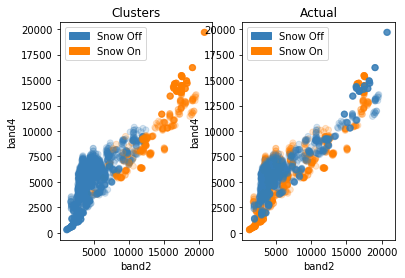

In [47]:
preds = gm
b1 = 'band2'
b2 = 'band4'
fig, (ax1, ax2) = plt.subplots(1, 2)
colors = np.array(['#377eb8', '#ff7f00'])
ax1.scatter(merged[b1], merged[b2], color=colors[preds], alpha=0.2)
ax1.set_title("Clusters")
ax1.set_xlabel(b1)
ax1.set_ylabel(b2)
ax2.scatter(merged[b1], merged[b2], color=colors[merged.label], alpha=0.2)
ax2.set_title("Actual")
ax2.set_xlabel(b1)
ax2.set_ylabel(b2)
nosnow_patch = patches.Patch(color=colors[0], label="Snow Off")
snow_patch = patches.Patch(color=colors[1], label='Snow On')
ax1.legend(handles=[nosnow_patch, snow_patch])
ax2.legend(handles=[nosnow_patch, snow_patch])
f.tight_layout()


In [48]:
incorrect = sum(abs(gm - merged.label)) / len(merged.label) # % incorrect
correct = 1-incorrect
print(correct)

0.6033962264150943
